In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from matplotlib.gridspec import GridSpec
from plots.mpltoolkit import named_colors, mpl_loc, fancy_legend, load_mpl_presets, append_axes, markers
import vice
vice.yields.ccsne.settings['o'] = 0.01
vice.yields.sneia.settings['o'] = 0
vice.yields.ccsne.settings['fe'] = 0.0008
vice.yields.sneia.settings['fe'] = 0.0011
from scipy.stats import multivariate_normal
import numpy as np
import math as m
import sys
sys.path.append("..")
from src.utils import exponential, chisquared
load_mpl_presets()
print(sys.version_info)

sys.version_info(major=3, minor=10, micro=2, releaselevel='final', serial=0)


In [2]:
raw = np.genfromtxt("../data/sgr/sgrchem.dat")
data = vice.dataframe({})
data["[fe/h]"] = raw[:, 0]
data["[fe/h]_err"] = raw[:, 1]
data["[o/fe]"] = raw[:, 2]
data["[o/fe]_err"] = raw[:, 3]

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\
/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: tau_star
  warnings.warn("""\


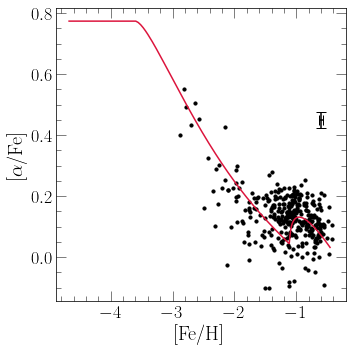

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")
# ax.set_xlim([-3.2, -0.2])
# ax.set_ylim([-0.2, 0.6])
# ax.set_yticks([-0.2, 0, 0.2, 0.4, 0.6])

# kwargs = {
#     "c": named_colors()["black"],
#     "linestyle": "None",
#     "xerr": data["[fe/h]_err"],
#     "yerr": data["[o/fe]_err"]
# }
# ax.errorbar(data["[fe/h]"], data["[o/fe]"], **kwargs)

kwargs = {
    "c": named_colors()["black"],
    "s": 10
}
ax.scatter(data["[fe/h]"], data["[o/fe]"], **kwargs)

med_feh_err = np.median(data["[fe/h]_err"])
med_ofe_err = np.median(data["[o/fe]_err"])
ax.errorbar(-0.6, 0.45, xerr = med_feh_err, yerr = med_ofe_err,
    c = named_colors()["black"])

def ifr(t):
    return t * np.exp(-t / 0.93)

def tstar(t):
    onset = 8.80
    rampup = 0.08
    top = 176.74
    bottom = 22.98
    if t < onset:
        return top
    elif onset <= t <= onset + rampup:
        return top - (top - bottom) / rampup * (t - onset)
    else:
        return bottom

with vice.singlezone(name = "sgrtest") as sz:
    vice.yields.ccsne.settings['fe'] = 0.00038
    vice.yields.sneia.settings['fe'] = 0.00224
    duration = 12.75
    sz.mode = "ifr"
    sz.func = ifr
    sz.tau_star = tstar
    sz.eta = 5.78
    sz.dt = duration / 1000
    bfout = sz.run(np.linspace(0, duration, 1001), overwrite = True, capture = True)
    ax.plot(out.history["[fe/h]"], out.history["[o/fe]"], c = named_colors()["crimson"])

plt.tight_layout()
plt.show()

In [19]:
quantities = list(filter(lambda _: not _.endswith("_err"), data.keys()))
sample = np.array([data[key] for key in quantities]).T
errors = np.array([data["%s_err" % (key)] for key in quantities]).T
model = len(bfout.history["time"]) * [None]
for i in range(len(model)):
    model[i] = len(quantities) * [0.]
    for j in range(len(quantities)):
        # no age information in the Sgr data (all distant giants)
        model[i][j] = bfout.history[quantities[j]][i]
model = model[1:] # chop off the -inf [Fe/H] predicted at t = 0
weights = bfout.history["sfr"][1:]
chisq = chisquared(sample, errors, model, weights)
print(chisq / (len(quantities) * len(sample) - 9))

5.366516818638337
